## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (7782)](http://neurovault.org/collections/7782/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler characteristics, Bland-Altman plots and Sørensen–Dice coefficients.


In [14]:
import os
from subprocess import check_call
import zipfile
from nilearn import plotting
import shutil
import pandas as pd

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 7782
 - Download and save the packs in sub-folder `input/ds109_amended/` 

In [15]:
from lib import download_data_amended
download_data_amended.download_data('7782', 'ds109', 'ds109_amended')

https://neurovault.org/collections/7782/group.gfeat.nidm.zip already downloaded at ./input/ds109_amended/group.gfeat.nidm.zip
https://neurovault.org/collections/7782/spm_0001.nidm.zip already downloaded at ./input/ds109_amended/spm_0001.nidm.zip
https://neurovault.org/collections/7782/spm_0002.nidm.zip already downloaded at ./input/ds109_amended/spm_0002.nidm.zip
https://neurovault.org/collections/7782/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds109_amended/afni_euler_chars.csv
https://neurovault.org/collections/7782/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds109_amended/spm_euler_chars.csv
https://neurovault.org/collections/7782/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds109_amended/fsl_euler_chars.csv
https://neurovault.org/collections/7782/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds1

In [21]:
from lib.bland_altman import z_to_t

study = 'ds109_amended'
num_subjects = 21

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)

# *** Euler Characteristics and Cluster Count
afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
afni_cluster_count = pd.read_csv('./input/' + study + '/afni_cluster_count.csv', usecols=[1], names=['AFNI Cluster Count'])
fsl_cluster_count = pd.read_csv('./input/' + study + '/fsl_cluster_count.csv', usecols=[1], names=['FSL Cluster Count'])
spm_cluster_count = pd.read_csv('./input/' + study + '/spm_cluster_count.csv', usecols=[1], names=['SPM Cluster Count'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars, afni_cluster_count, fsl_cluster_count, spm_cluster_count], axis=1)

# *** Permutation Test images
afni_perm = './input/' + study + '/afni_perm.nii.gz'
afni_perm_pos_exc = './input/' + study + '/afni_perm_exc_set_pos.nii.gz'
afni_perm_mask = './input/' + study + '/afni_mask_perm.nii.gz'

# Convert AFNI permutation z-stats images to t-stat
z_to_t(afni_perm, afni_perm.replace('.nii.gz', '_t.nii.gz'), num_subjects)
z_to_t(afni_perm_pos_exc, afni_perm_pos_exc.replace('.nii.gz', '_t.nii.gz'), num_subjects)
afni_perm_t = './input/' + study + '/afni_perm_t.nii.gz'
afni_perm_pos_exc_t = './input/' + study + '/afni_perm_exc_set_pos_t.nii.gz'

fsl_perm = './input/' + study + '/fsl_perm.nii.gz'
fsl_perm_pos_exc = './input/' + study + '/fsl_perm_exc_set_pos.nii.gz'
fsl_perm_neg_exc = './input/' + study + '/fsl_perm_exc_set_neg.nii.gz'
spm_perm = './input/' + study + '/spm_perm.nii.gz'
spm_perm_pos_exc = './input/' + study + '/spm_perm_exc_set_pos.nii.gz'

perm_exc_sets = dict()
perm_exc_sets["spm permutation"] = (spm_mask_file, spm_perm_pos_exc, spm_perm)
perm_exc_sets["fsl permutation"] = (fsl_mask_file, (fsl_perm_pos_exc, fsl_perm_neg_exc), fsl_perm)
perm_exc_sets["afni permutation"] = (afni_perm_mask, afni_perm_pos_exc_t, afni_perm_t)

# *** Permutation Test Euler Characteristics and Cluster Count
afni_perm_euler_chars = pd.read_csv('./input/' + study + '/afni_perm_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_perm_euler_chars = pd.read_csv('./input/' + study + '/fsl_perm_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_perm_euler_chars = pd.read_csv('./input/' + study + '/spm_perm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
afni_perm_cluster_count = pd.read_csv('./input/' + study + '/afni_perm_cluster_count.csv', usecols=[1], names=['AFNI Cluster Count'])
fsl_perm_cluster_count = pd.read_csv('./input/' + study + '/fsl_perm_cluster_count.csv', usecols=[1], names=['FSL Cluster Count'])
spm_perm_cluster_count = pd.read_csv('./input/' + study + '/spm_perm_cluster_count.csv', usecols=[1], names=['SPM Cluster Count'])
perm_euler_chars = pd.concat([afni_perm_euler_chars, fsl_perm_euler_chars, spm_perm_euler_chars, afni_perm_cluster_count, fsl_perm_cluster_count, spm_perm_cluster_count], axis=1)

# *** BOLD images
afni_bold = './input/' + study + '/afni_bold.nii.gz'
fsl_bold = './input/' + study + '/fsl_bold.nii.gz'
spm_bold = './input/' + study + '/spm_bold.nii.gz'

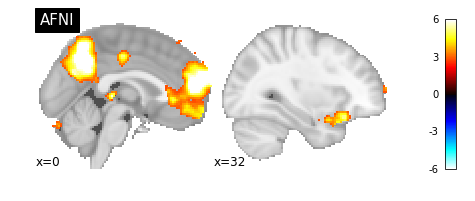

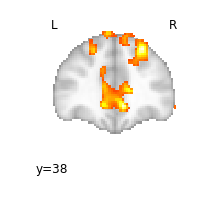

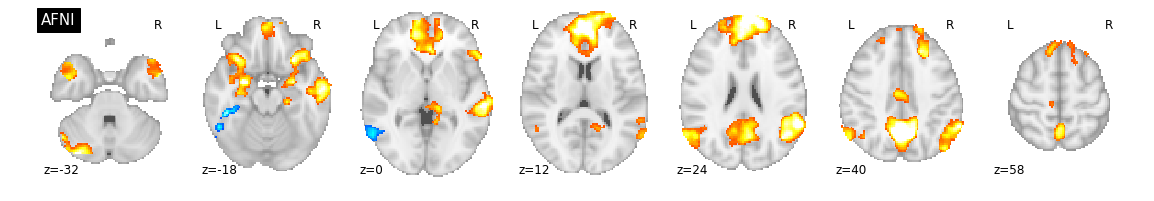

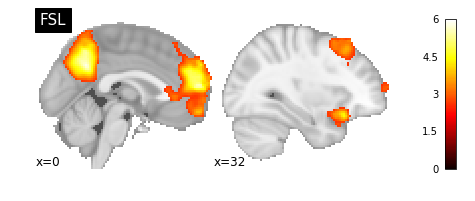

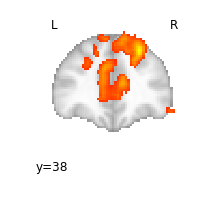

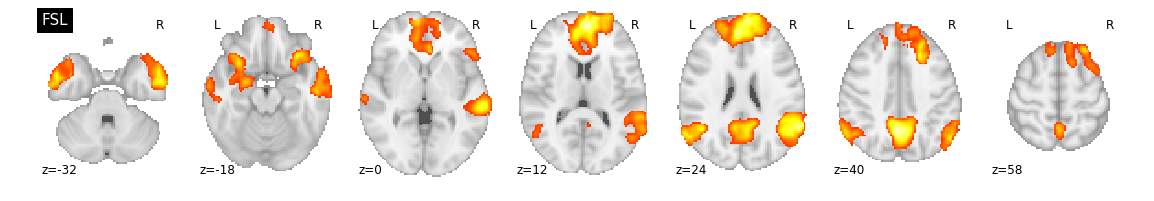

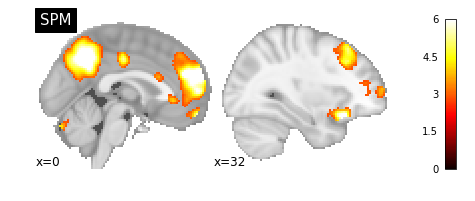

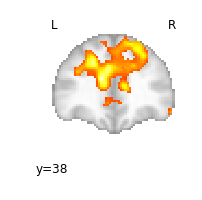

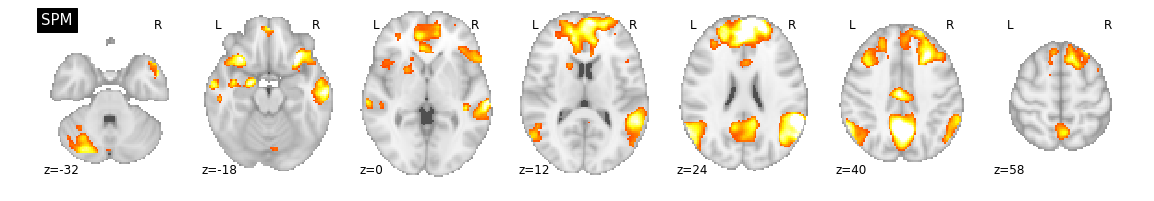

In [22]:
from lib import plot_excursion_sets
# Determine the scale of the activation colorbar
max_activation=6
# Determine the coordinates of the x, y, and z axial slices to be displayed
x_coords=[0, 32]
y_coords=[38]
z_coords=[-32, -18, 0, 12, 24, 40, 58]

plot_excursion_sets.plot_excursion_sets(exc_sets, max_activation, x_coords, y_coords, z_coords)

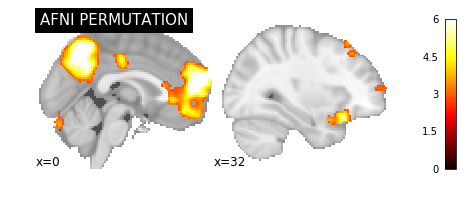

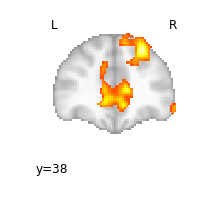

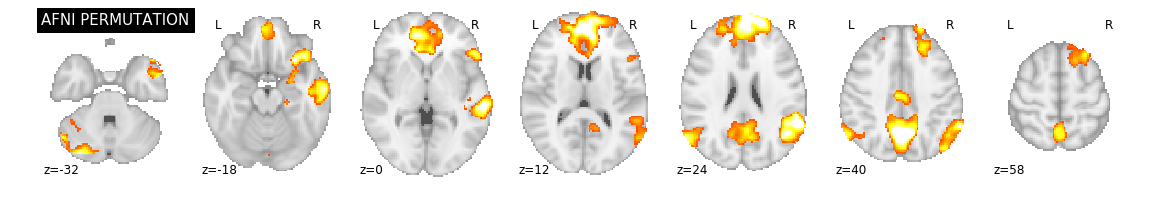

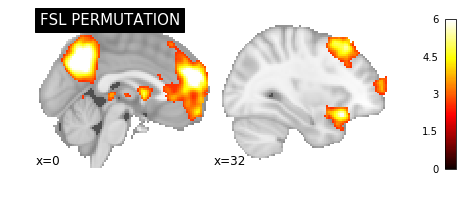

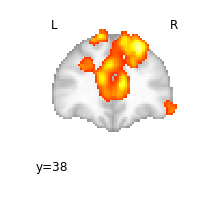

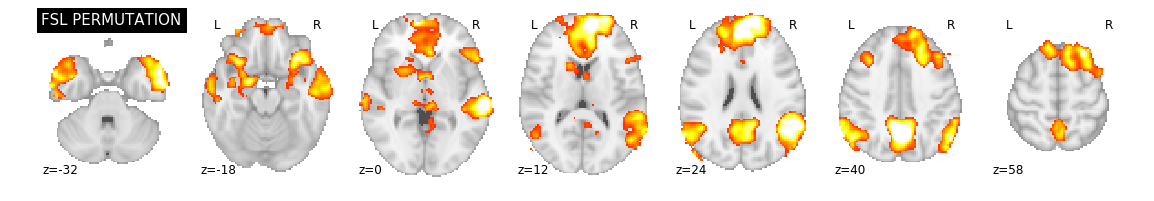

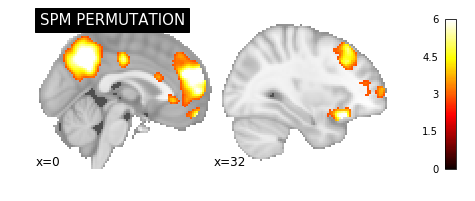

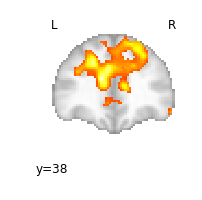

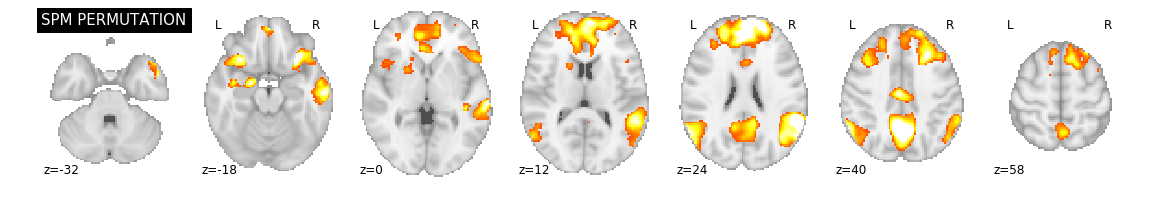

In [23]:
# Plot t-statistic images for permutation test inference results in each software
plot_excursion_sets.plot_excursion_sets(perm_exc_sets, max_activation, x_coords, y_coords, z_coords)

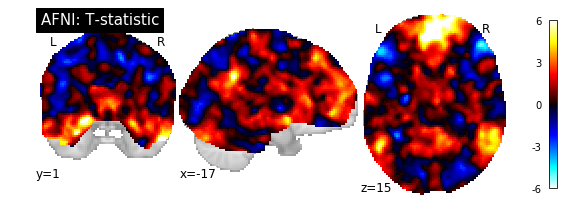

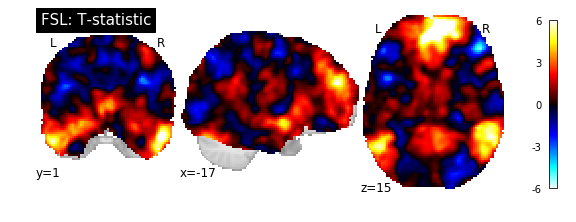

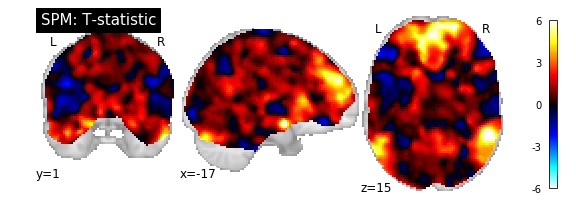

In [24]:
from lib import plot_stat_images
plot_stat_images.plot_stat_images(afni_stat_file, spm_stat_file, max_activation, [-17, 1, 15], 'T-statistic', fsl_stat_file)

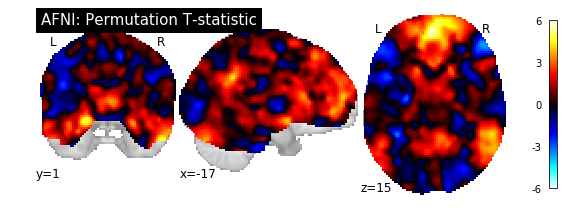

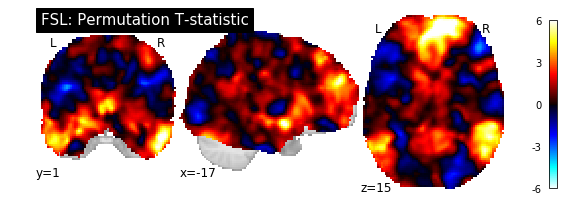

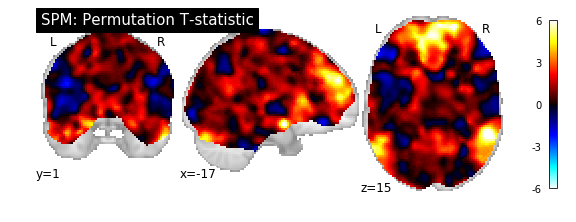

In [25]:
plot_stat_images.plot_stat_images(afni_perm, spm_perm, max_activation, [-17, 1, 15], 'Permutation T-statistic', fsl_perm)

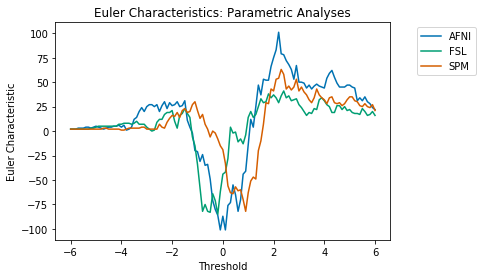

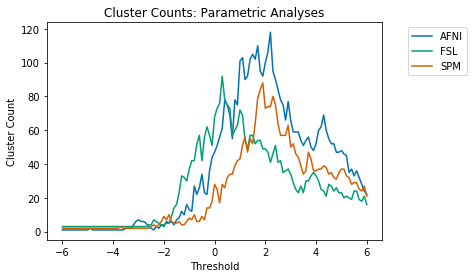

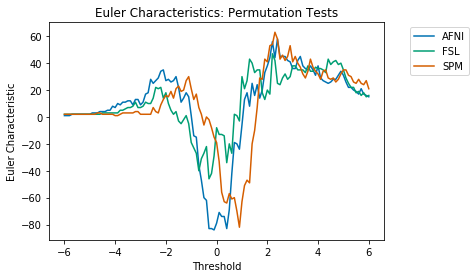

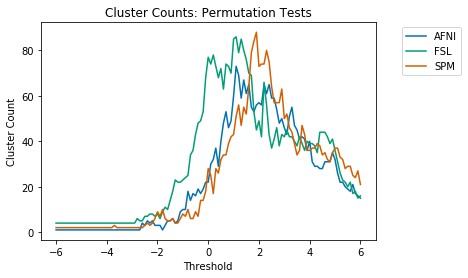

In [26]:
from lib import euler_characteristics
reload(euler_characteristics)
euler_characteristics.euler_characteristics(euler_chars, 'Parametric Analyses')
euler_characteristics.euler_characteristics(perm_euler_chars, 'Permutation Tests')

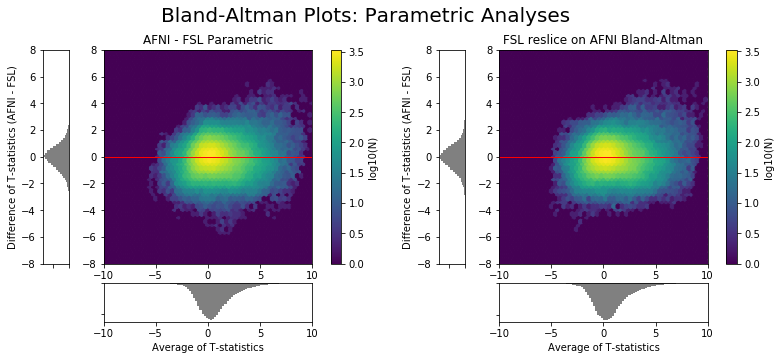

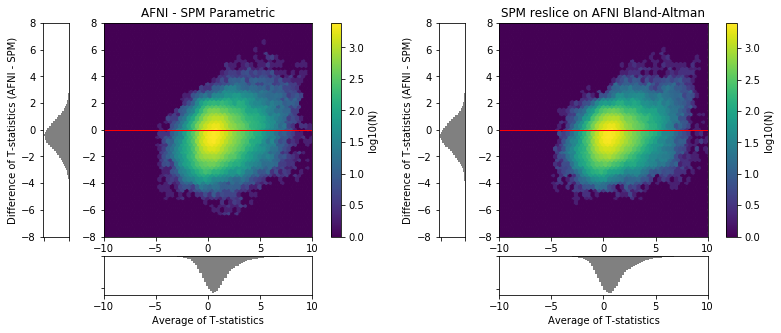

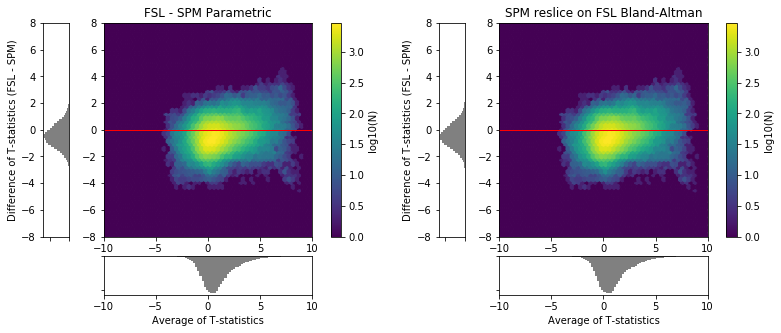

In [27]:
from lib import bland_altman
bland_altman.bland_altman('Bland-Altman Plots: Parametric Analyses', afni_stat_file, spm_stat_file,
            'AFNI - SPM Parametric', 'AFNI - FSL Parametric', 'FSL - SPM Parametric',
             fsl_stat_file, study=study)

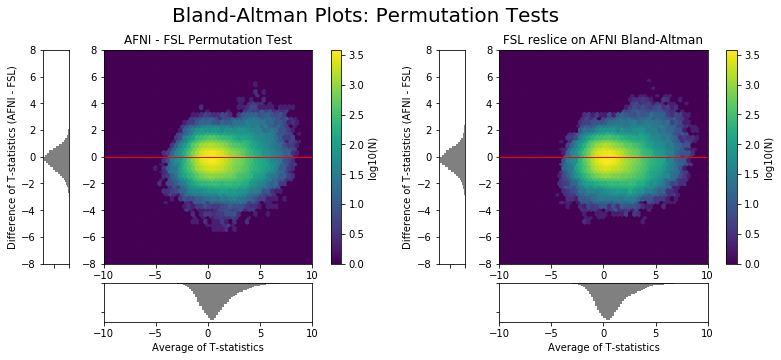

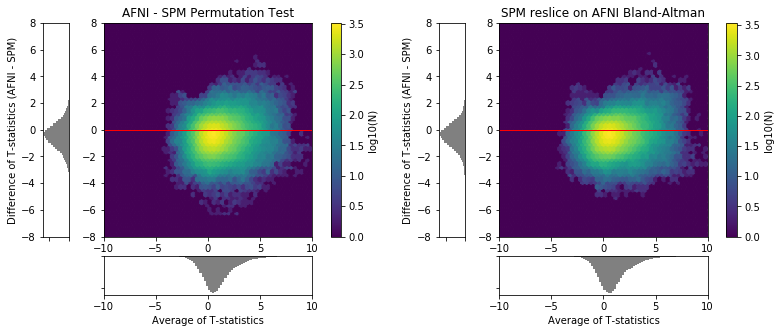

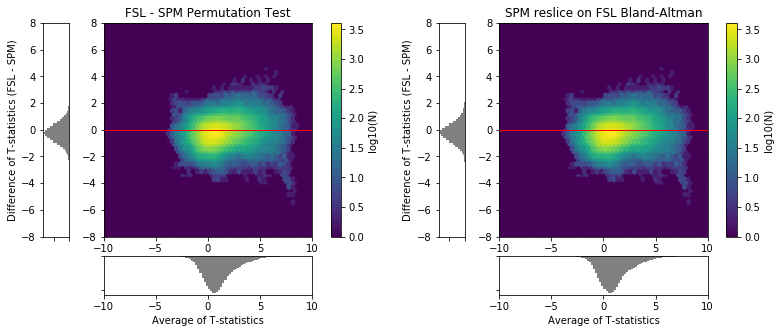

In [28]:
bland_altman.bland_altman('Bland-Altman Plots: Permutation Tests', afni_perm, spm_perm,
            'AFNI - SPM Permutation Test', 'AFNI - FSL Permutation Test', 'FSL - SPM Permutation Test',
             fsl_perm, num_subjects=num_subjects, study=study + '_perm')

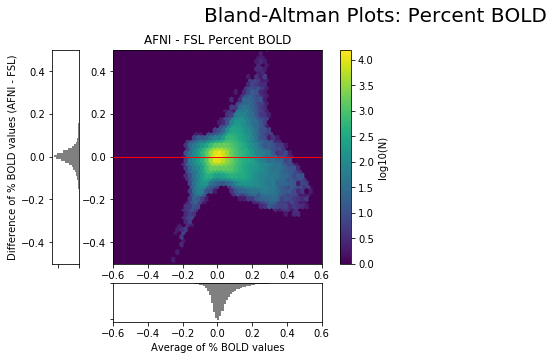

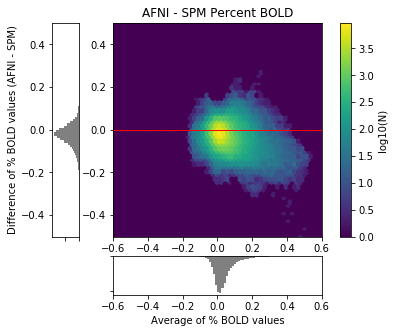

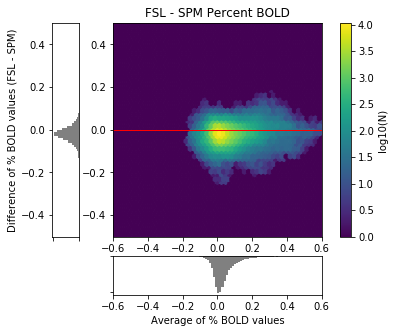

In [29]:
reload(bland_altman)
bland_altman.bland_altman_bold('Bland-Altman Plots: Percent BOLD', afni_bold, spm_bold,
            'AFNI - SPM Percent BOLD', 'AFNI - FSL Percent BOLD', 'FSL - SPM Percent BOLD',
             fsl_bold, study=study + '_bold')

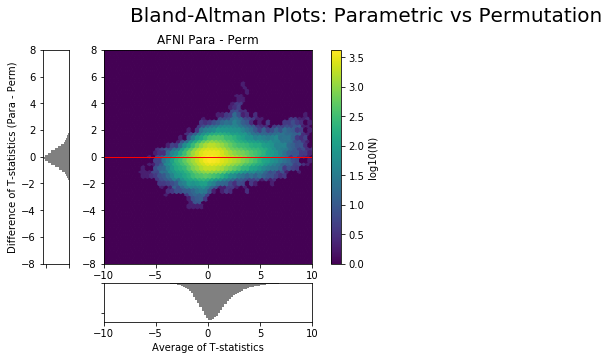

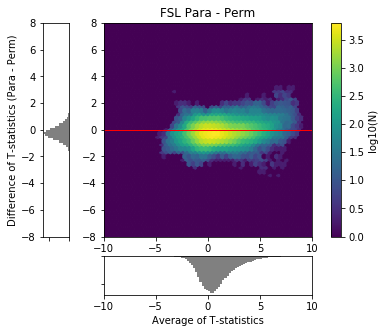

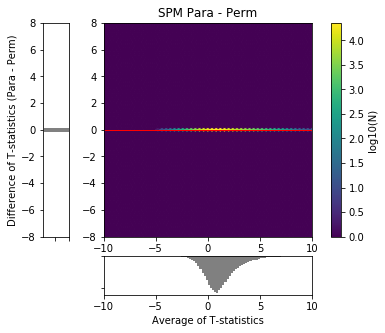

In [30]:
bland_altman.bland_altman_intra('Bland-Altman Plots: Parametric vs Permutation', afni_stat_file, afni_perm,
             fsl_stat_file, fsl_perm,
             spm_stat_file, spm_perm, num_subjects=num_subjects, 
             study=study + '_permintra')

AFNI/FSL positive activation dice coefficient = 0.722774, 9, 2
AFNI/SPM positive activation dice coefficient = 0.642180, 0, 15
FSL/SPM positive activation dice coefficient = 0.755689, 1, 22
Permutation test AFNI/SPM positive activation dice coefficient = 0.672886, 0, 15
Permutation test AFNI/FSL positive activation dice coefficient = 0.661246, 10, 2
Permutation test FSL/SPM positive activation dice coefficient = 0.768594, 0, 23
AFNI classical inference/permutation test positive activation dice coefficient = 0.819258, 0, 0
FSL classical inference/permutation test positive activation dice coefficient = 0.808453, 0, 0
SPM classical inference/permutation test positive activation dice coefficient = 0.970059, 0, 0
AFNI parametric/FSL permutation positive activation dice coefficient = 0.668829, 10, 2
AFNI parametric/SPM permutation positive activation dice coefficient = 0.649645, 0, 15
FSL parametric/AFNI permutation positive activation dice coefficient = 0.702501, 2, 9
FSL parametric/SPM per

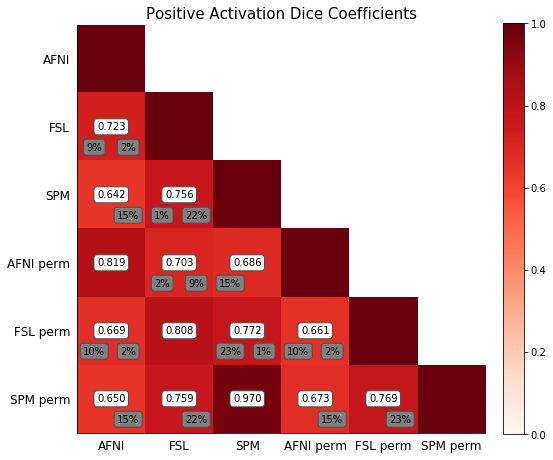

In [20]:
from lib import dice
reload(dice)
dice.dice(afni_exc_set_file, spm_exc_set_file, 
         afni_perm_pos_exc, spm_perm_pos_exc,
         afni_exc_set_file_neg, spm_exc_set_file_neg,
         fsl_exc_set_file, None, 
         fsl_perm_pos_exc, study=study,
         afni_stat_file=afni_stat_file, fsl_stat_file=fsl_stat_file, spm_stat_file=spm_stat_file,
         afni_perm=afni_perm, fsl_perm=fsl_perm, spm_perm=spm_perm,
         )